# Introduction à la régression

Lino Galiana  
2025-03-19

<div class="badge-container"><div class="badge-text">Pour essayer les exemples présents dans ce tutoriel :</div><a href="https://github.com/linogaliana/python-datascientist-notebooks/blob/main/notebooks/modelisation/3_regression.ipynb" target="_blank" rel="noopener"><img src="https://img.shields.io/static/v1?logo=github&label=&message=View%20on%20GitHub&color=181717" alt="View on GitHub"></a>
<a href="https://datalab.sspcloud.fr/launcher/ide/vscode-python?autoLaunch=true&name=«3_regression»&init.personalInit=«https%3A%2F%2Fraw.githubusercontent.com%2Flinogaliana%2Fpython-datascientist%2Fmain%2Fsspcloud%2Finit-vscode.sh»&init.personalInitArgs=«modelisation%203_regression%20correction»" target="_blank" rel="noopener"><img src="https://custom-icon-badges.demolab.com/badge/SSP%20Cloud-Lancer_avec_VSCode-blue?logo=vsc&logoColor=white" alt="Onyxia"></a>
<a href="https://datalab.sspcloud.fr/launcher/ide/jupyter-python?autoLaunch=true&name=«3_regression»&init.personalInit=«https%3A%2F%2Fraw.githubusercontent.com%2Flinogaliana%2Fpython-datascientist%2Fmain%2Fsspcloud%2Finit-jupyter.sh»&init.personalInitArgs=«modelisation%203_regression%20correction»" target="_blank" rel="noopener"><img src="https://img.shields.io/badge/SSP%20Cloud-Lancer_avec_Jupyter-orange?logo=Jupyter&logoColor=orange" alt="Onyxia"></a>
<a href="https://colab.research.google.com/github/linogaliana/python-datascientist-notebooks-colab//blob/main//notebooks/modelisation/3_regression.ipynb" target="_blank" rel="noopener"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a><br></div>

Le précédent chapitre visait à proposer un premier modèle pour comprendre
les comtés où le parti Républicain l’emporte. La variable d’intérêt étant
bimodale (victoire ou défaite), on était dans le cadre d’un modèle de
classification.

Maintenant, sur les mêmes données, on va proposer un modèle de régression
pour expliquer le score du parti Républicain. La variable est donc continue.
Nous ignorerons le fait que ses bornes se trouvent entre 0 et 100 et donc
qu’il faudrait, pour être rigoureux, transformer l’échelle afin d’avoir
des données dans cet intervalle.

Ce chapitre utilise toujours le même jeu de données, présenté dans l’[introduction
de cette partie](index.qmd) : les données de vote aux élections présidentielles américaines
croisées à des variables sociodémographiques.
Le code
est disponible [sur Github](https://github.com/linogaliana/python-datascientist/blob/main/content/modelisation/get_data.py).

In [1]:
!pip install --upgrade xlrd #colab bug verson xlrd
!pip install geopandas

In [2]:
import pandas as pd

In [3]:
import requests

url = 'https://raw.githubusercontent.com/linogaliana/python-datascientist/main/content/modelisation/get_data.py'
r = requests.get(url, allow_redirects=True)
open('getdata.py', 'wb').write(r.content)

import getdata
votes = getdata.create_votes_dataframes()

Ce chapitre va utiliser plusieurs *packages*
de modélisation, les principaux étant `Scikit` et `Statsmodels`.
Voici une suggestion d’import pour tous ces *packages*.

In [4]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import sklearn.metrics
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Principe général

Le principe général de la régression consiste à trouver une loi $h_\theta(X)$
telle que

$$
h_\theta(X) = \mathbb{E}_\theta(Y|X)
$$

Cette formalisation est extrêmement généraliste et ne se restreint d’ailleurs
pas à la régression linéaire.

En économétrie, la régression offre une alternative aux méthodes de maximum
de vraisemblance et aux méthodes des moments. La régression est un ensemble
très vaste de méthodes, selon la famille de modèles
(paramétriques, non paramétriques, etc.) et la structure de modèles.

## 1.1 La régression linéaire

C’est la manière la plus simple de représenter la loi $h_\theta(X)$ comme
combinaison linéaire de variables $X$ et de paramètres $\theta$. Dans ce
cas,

$$
\mathbb{E}_\theta(Y|X) = X\beta
$$

Cette relation est encore, sous cette formulation, théorique. Il convient
de l’estimer à partir des données observées $y$. La méthode des moindres
carrés consiste à minimiser l’erreur quadratique entre la prédiction et
les données observées (ce qui explique qu’on puisse voir la régression comme
un problème de *Machine Learning*). En toute généralité, la méthode des
moindres carrés consiste à trouver l’ensemble de paramètres $\theta$
tel que

$$
\theta = \arg \min_{\theta \in \Theta} \mathbb{E}\bigg[ \left( y - h_\theta(X) \right)^2 \bigg]
$$

Ce qui, dans le cadre de la régression linéaire, s’exprime de la manière suivante :

$$
\beta = \arg\min \mathbb{E}\bigg[ \left( y - X\beta \right)^2 \bigg]
$$

Lorsqu’on amène le modèle théorique ($\mathbb{E}_\theta(Y|X) = X\beta$) aux données,
on formalise le modèle de la manière suivante :

$$
Y = X\beta + \epsilon
$$

Avec une certaine distribution du bruit $\epsilon$ qui dépend
des hypothèses faites. Par exemple, avec des
$\epsilon \sim \mathcal{N}(0,\sigma^2)$ i.i.d., l’estimateur $\beta$ obtenu
est équivalent à celui du Maximum de Vraisemblance dont la théorie asymptotique
nous assure l’absence de biais, la variance minimale (borne de Cramer-Rao).

### 1.1.1 Application

Toujours sous le patronage des héritiers de Siegfried (1913), notre objectif, dans ce chapitre, est d’expliquer et prédire le score des Républicains à partir de quelques
variables socioéconomiques. Contrairement au chapitre précédent, où on se focalisait sur
un résultat binaire (victoire/défaite des Républicains), cette
fois on va chercher à modéliser directement le score des Républicains.

Le prochain exercice vise à illustrer la manière d’effectuer une régression linéaire avec `scikit`.
Dans ce domaine,
`statsmodels` est nettement plus complet, ce que montrera l’exercice suivant.
L’intérêt principal de faire
des régressions avec `scikit` est de pouvoir comparer les résultats d’une régression linéaire
avec d’autres modèles de régression dans une perspective de sélection du meilleur modèle prédictif.

<div class="alert alert-success" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-pencil"></i> Exercice 1a : Régression linéaire avec scikit</h3>

1.  A partir de quelques variables, par exemple, *‘Unemployment_rate_2019’, ‘Median_Household_Income_2021’, ‘Percent of adults with less than a high school diploma, 2018-22’, “Percent of adults with a bachelor’s degree or higher, 2018-22”*, expliquer la variable `per_gop` à l’aide d’un échantillon d’entraînement `X_train` constitué au préalable.

⚠️ Utiliser la variable `Median_Household_Income_2021`
en `log` sinon son échelle risque d’écraser tout effet.

1.  Afficher les valeurs des coefficients, constante comprise

2.  Evaluer la pertinence du modèle avec le $R^2$ et la qualité du fit avec le MSE.

3.  Représenter un nuage de points des valeurs observées
    et des erreurs de prédiction. Observez-vous
    un problème de spécification ?

</div>

In [5]:
# Question 1
xvars = [
  'Unemployment_rate_2019', 'Median_Household_Income_2021',
  'Percent of adults with less than a high school diploma, 2018-22',
  "Percent of adults with a bachelor's degree or higher, 2018-22"
]


df2 = (
  votes.loc[:,["per_gop"] + xvars]
  .dropna()
  .copy()
)
df2['log_income'] = np.log(df2["Median_Household_Income_2021"])
df2 = df2.dropna().astype(np.float64)


X_train, X_test, y_train, y_test = train_test_split(
    df2.drop(["Median_Household_Income_2021","per_gop"], axis = 1),
    100*df2[['per_gop']].values.ravel(), test_size=0.2, random_state=0
)

ols = LinearRegression().fit(X_train, y_train)
y_pred = ols.predict(X_test)

In [6]:
# Question 2
print(ols.intercept_, ols.coef_)

In [7]:
# Question 3

rmse = sklearn.metrics.root_mean_squared_error(y_test, y_pred)
rsq = sklearn.metrics.r2_score(y_test, y_pred) 

print(
  f'Root mean squared error: {rmse:.2f}'
)

print(
  f'Coefficient of determination: {rsq:.2f}'
)

À la question 4, on peut voir que la répartition des erreurs n’est clairement pas aléatoire en fonction de $X$.

In [8]:
#4. Nuage de points des valeurs observées
tempdf = pd.DataFrame(
  {
    "prediction": y_pred, "observed": y_test,
    "error": y_test - y_pred
  }
)

fig = plt.figure()
g = sns.scatterplot(data = tempdf, x = "observed", y = "error")
g.axhline(0, color = "red")

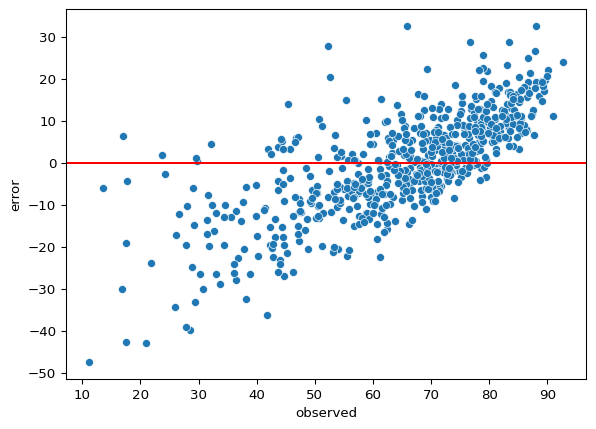

In [9]:
g.figure.get_figure()

Le modèle souffre donc d’un problème de spécification, il faudra par la suite faire un travail sur les variables sélectionnées. Avant cela, on peut refaire cet exercice avec le *package* `statsmodels`.

In [10]:
# packages utiles
import statsmodels.api as sm
import statsmodels.formula.api as smf

<div class="alert alert-success" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-pencil"></i> Exercice 1b : Régression linéaire avec statsmodels</h3>

Cet exercice vise à illustrer la manière d’effectuer une régression linéaire avec `statsmodels` qui offre des fonctionnalités plus proches de celles de `R`, et moins orientées *Machine Learning*.

L’objectif est toujours d’expliquer le score des Républicains en fonction de quelques
variables.

1.  A partir de quelques variables, par exemple, *‘Unemployment_rate_2019’, ‘Median_Household_Income_2021’, ‘Percent of adults with less than a high school diploma, 2018-22’, “Percent of adults with a bachelor’s degree or higher, 2018-22”*, expliquer la variable `per_gop`.
    ⚠️ utiliser la variable `Median_Household_Income_2021`
    en `log` sinon son échelle risque d’écraser tout effet.
2.  Afficher un tableau de régression.
3.  Evaluer la pertinence du modèle avec le R^2.
4.  Utiliser l’API `formula` pour régresser le score des républicains en fonction de la variable `Unemployment_rate_2021`, de `Unemployment_rate_2019` au carré et du log de
    `Median_Household_Income_2021`.

</div>

In [11]:
# Question 1
xvars = [
  'Unemployment_rate_2019', 'Median_Household_Income_2021',
  'Percent of adults with less than a high school diploma, 2018-22',
  "Percent of adults with a bachelor's degree or higher, 2018-22"
]

df2 = (
  votes.loc[:,["per_gop"] + xvars]
  .dropna()
  .copy()
)
df2['log_income'] = np.log(df2["Median_Household_Income_2021"])
df2 = df2.dropna().astype(np.float64)

X = sm.add_constant(df2.drop(["Median_Household_Income_2021","per_gop"], axis = 1))
results = sm.OLS(df2[['per_gop']], X).fit()

In [12]:
# Question 2
print(results.summary())

In [13]:
# 3. Calcul du R^2
print("R2: ", results.rsquared)

R2:  0.4310933195576123

In [14]:
# 4. Nouvelle régression avec l'API formula
results = smf.ols('per_gop ~ Unemployment_rate_2019 + I(Unemployment_rate_2019**2) + np.log(Median_Household_Income_2021)', data=df2).fit()
print(results.summary())

<div class="alert alert-success" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-lightbulb"></i> Tip</h3>

Pour sortir une belle table pour un rapport sous $\LaTeX$, il est possible d’utiliser
la méthode [`Summary.as_latex`](https://www.statsmodels.org/devel/generated/statsmodels.iolib.summary.Summary.as_latex.html#statsmodels.iolib.summary.Summary.as_latex). Pour un rapport HTML, on utilisera [`Summary.as_html`](https://www.statsmodels.org/devel/generated/statsmodels.iolib.summary.Summary.as_latex.html#statsmodels.iolib.summary.Summary.as_latex)

</div>

<div class="alert alert-info" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-comment"></i> Note</h3>

Les utilisateurs de `R` retrouveront des éléments très familiers avec `statsmodels`,
notamment la possibilité d’utiliser une formule pour définir une régression.
La philosophie de `statsmodels` est similaire à celle qui a influé sur la construction
des packages `stats` et `MASS` de `R`: offrir une librairie généraliste, proposant
une large gamme de modèles.

Néanmoins, `statsmodels` bénéficie de sa jeunesse
par rapport aux packages `R`. Depuis les années 1990, les packages `R` visant
à proposer des fonctionalités manquantes dans `stats` et `MASS` se sont
multipliés alors que `statsmodels`, enfant des années 2010, n’a eu qu’à
proposer un cadre général (les *generalized estimating equations*) pour
englober ces modèles.

</div>

## 1.2 La régression logistique

Nous avons appliqué notre régression linéaire sur une variable d’*outcome* continue.
Comment faire avec une distribution binaire ?  
Dans ce cas, $\mathbb{E}_{\theta} (Y|X) = \mathbb{P}_{\theta} (Y = 1|X)$.  
La régression logistique peut être vue comme un modèle linéaire en probabilité :

$$
\text{logit}\bigg(\mathbb{E}_{\theta}(Y|X)\bigg) = \text{logit}\bigg(\mathbb{P}_{\theta}(Y = 1|X)\bigg) = X\beta
$$

La fonction $\text{logit}$ est $]0,1[ \to \mathbb{R}: p \mapsto \log(\frac{p}{1-p})$.

Elle permet ainsi de transformer une probabilité dans $\mathbb{R}$.
Sa fonction réciproque est la sigmoïde ($\frac{1}{1 + e^{-x}}$),
objet central du *Deep Learning*.

Il convient de noter que les probabilités ne sont pas observées, c’est l’*outcome*
binaire (0/1) qui l’est. Cela amène à voir la régression logistique de deux
manières différentes :

-   En économétrie, on s’intéresse au modèle latent qui détermine le choix de
    l’outcome. Par exemple, si on observe les choix de participer ou non au marché
    du travail, on va modéliser les facteurs déterminant ce choix ;
-   En *Machine Learning*, le modèle latent n’est nécessaire que pour classifier
    dans la bonne catégorie les observations.

L’estimation des paramètres $\beta$ peut se faire par maximum de vraisemblance
ou par régression, les deux solutions sont équivalentes sous certaines
hypothèses.

<div class="alert alert-info" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-comment"></i> Note</h3>

Par défaut, `scikit` applique une régularisation pour pénaliser les modèles
peu parcimonieux (comportement différent
de celui de `statsmodels`). Ce comportement par défaut est à garder à l’esprit
si l’objectif n’est pas de faire de la prédiction.

</div>

<div class="alert alert-info" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-comment"></i> Note</h3>

By default, `scikit` applies regularization to penalize non-parsimonious models (a behavior different from that of `statsmodels`). This default behavior should be kept in mind if the objective is not prediction.

</div>

In [15]:
# packages utiles
from sklearn.linear_model import LogisticRegression
import sklearn.metrics

<div class="alert alert-success" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-pencil"></i> Exercice 2a : Régression logistique avec scikit</h3>

Avec `scikit`, en utilisant échantillons d’apprentissage et d’estimation :

1.  Evaluer l’effet des variables déjà utilisées sur la probabilité des Républicains
    de gagner. Affichez la valeur des coefficients.
2.  Déduire une matrice de confusion et
    une mesure de qualité du modèle.
3.  Supprimer la régularisation grâce au paramètre `penalty`. Quel effet sur les paramètres estimés ?

</div>

In [16]:
#1. Modèle logit avec les mêmes variables que précédemment
xvars = [
  'Unemployment_rate_2019', 'Median_Household_Income_2021',
  'Percent of adults with less than a high school diploma, 2018-22',
  "Percent of adults with a bachelor's degree or higher, 2018-22"
]

df2 = votes.loc[:, ["per_gop"] + xvars].copy()
df2['log_income'] = np.log(df2["Median_Household_Income_2021"])
df2 = df2.dropna().astype(np.float64)


df2['y'] = (df2['per_gop']>0.5).astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    df2.drop(["Median_Household_Income_2021","y"], axis = 1),
    1*df2[['y']].values.ravel(), test_size=0.2, random_state=0
)

clf = LogisticRegression().fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(clf.intercept_, clf.coef_)

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay

# 2. Matrice de confusion
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

sc_accuracy = sklearn.metrics.accuracy_score(y_pred, y_test)
sc_f1 = sklearn.metrics.f1_score(y_pred, y_test)
sc_recall = sklearn.metrics.recall_score(y_pred, y_test)
sc_precision = sklearn.metrics.precision_score(y_pred, y_test)

print(sc_accuracy)
print(sc_f1)
print(sc_recall)
print(sc_precision)

In [18]:
#3. Supprimer la régularisation
clf2 = LogisticRegression(penalty=None).fit(X_train, y_train)
y_pred2 = clf.predict(X_test)
print(clf2.intercept_, clf2.coef_)
# Les coefficients sont complètement différents

In [19]:
# packages utiles
from scipy import stats

<div class="alert alert-success" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-pencil"></i> Exercice 2b : Régression logistique avec statmodels</h3>

En utilisant échantillons d’apprentissage et d’estimation :

1.  Evaluer l’effet des variables déjà utilisées sur la probabilité des Républicains
    de gagner.
2.  Faire un test de ratio de vraisemblance concernant l’inclusion de la variable de (log)-revenu.

</div>

In [20]:
#1. Modèle logit avec les mêmes variables que précédemment
xvars = [
  'Unemployment_rate_2021', 'Median_Household_Income_2021',
  'Percent of adults with less than a high school diploma, 2018-22',
  "Percent of adults with a bachelor's degree or higher, 2018-22"]

df2 = votes[["per_gop"] + xvars]
df2['log_income'] = np.log(df2["Median_Household_Income_2021"])
df2 = df2.dropna().astype(np.float64)

df2['y'] = (df2['per_gop']>0.5).astype(int)

mylogit = smf.logit(
  formula = 'y ~ Unemployment_rate_2021 + I(Unemployment_rate_2021**2) + np.log(Median_Household_Income_2021)',
  data=df2[df2['Median_Household_Income_2021']>0]).fit()
print(mylogit.summary())

In [21]:
#2. Faire un test de ratio de vraisemblance 
logit_h0 = smf.logit(
  formula = 'y ~ Unemployment_rate_2021 + I(Unemployment_rate_2021**2)',
  data=df2[df2['Median_Household_Income_2021']>0]).fit()
# print(logit_h0.summary())

lr = -2*(mylogit.llf - logit_h0.llf)
lrdf = (logit_h0.df_resid - mylogit.df_resid)

lr_pvalue = stats.chi2.sf(lr, df=lrdf)
lr_pvalue

La p-value du test de maximum de ratio de vraisemblance étant proche de 1, cela signifie que la variable log revenu ajoute,
presque à coup sûr, de l’information au modèle.

<div class="alert alert-success" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-lightbulb"></i> Tip</h3>

La statistique du test est :
$$
LR = -2\log\bigg(\frac{\mathcal{L}_{\theta}}{\mathcal{L}_{\theta_0}}\bigg) = -2(\mathcal{l}_{\theta} - \mathcal{l}_{\theta_0})
$$

</div>

# 2. Pour aller plus loin

Ce chapitre n’évoque les enjeux de la régression
que de manière très introductive. Pour compléter ceci,
il est recommandé d’aller plus loin en fonction de vos centres d’intérêt et de vos besoins.

Dans le domaine du *machine learning*, les principales voies d’approfondissement sont les suivantes:

-   Les modèles de régression alternatifs comme les forêts
    aléatoires.
-   Les méthodes de *boosting* et *bagging* pour découvrir la manière dont plusieurs modèles peuvent être entraînés de manière conjointe et leur prédiction sélectionnée selon un principe démocratique pour converger vers une meilleure décision qu’un modèle simple.
-   Les enjeux liés à l’explicabilité des modèles, un champ de recherche très actif, pour mieux comprendre les critères de décision des modèles.

Dans le domaine de l’économétrie, les principales voies d’approfondissement sont les suivantes:

-   Les modèles linéaires généralisés pour découvrir la régression
    avec des hypothèses plus générales que celles que nous avons posées
    jusqu’à présent ;
-   Les tests d’hypothèses pour aller plus loin sur ces questions que notre
    test de ratio de vraisemblance.

## Références

Siegfried, André. 1913. *Tableau politique de la France de l’ouest sous la troisième république: 102 cartes et croquis, 1 carte hors texte*. A. Colin.